In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from scipy.stats import lognorm

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import imageio
from torch.optim.lr_scheduler import StepLR, ExponentialLR

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pwd

/Users/bruno/projects/causality-demo/notebooks


In [4]:
sns.set_style('white')

matplotlib.rcParams['figure.figsize'] = 8, 6
matplotlib.rcParams['figure.dpi'] = 80

In [5]:
from causalitydemos.datasets import lotka_volterra
from causalitydemos.training import Trainer, CondVAETrainer
from causalitydemos.models import SinFeatureNetwork, NeuralNetwork, ConditionalVAE

In [6]:
time_delta = 1.0
params = np.array((1.5, 1.2, 0.7, 0.9))*1e-2
simulator = lotka_volterra.LotkaVolterraSimulator(*params)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


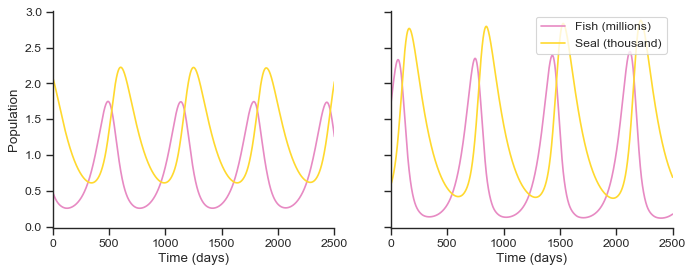

In [7]:
num_steps = 2501
sim_data = []
for i in range(2):
    sim_data.append(simulator.run_simulation_with_fixed_int(
        np.random.lognormal()*1.5, np.random.lognormal(), num_steps - 1, time_delta=time_delta))
steps = np.arange(num_steps)

colors = sns.color_palette('Set2')
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(ncols=2, figsize=(10,3.6), sharey=True)
    for i in range(2):
        axes[i].plot(steps*time_delta, sim_data[i][:, 0], color=colors[3], label='Fish (millions)')
        axes[i].plot(steps*time_delta, sim_data[i][:, 1], color=colors[5], label='Seal (thousand)')
        axes[i].set_xlim((0, (steps*time_delta)[-1]))
        axes[i].set_xlabel('Time (days)')
    axes[0].set_ylabel('Population')
    sns.despine()
    plt.legend(loc='upper right')

plt.savefig('../plots/example_lotka_volterra_dynamics.eps', bbox_inches='tight', format='eps')

In [8]:
dataset = lotka_volterra.VariableStepLotkaVolterraDataset(
    simulator, size=5000, min_time_delta=1e-5, max_time_delta=10., samples_per_sim=100, seed=3,
    transform=lotka_volterra.ToTensor())

100%|██████████| 50/50 [00:00<00:00, 786.46it/s]


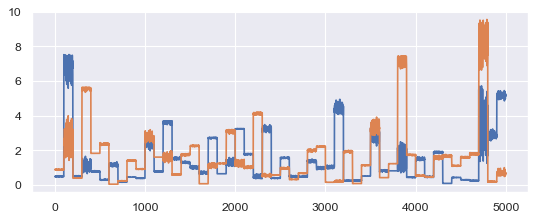

In [9]:
plt.figure(figsize=(8, 3))
plt.plot(np.arange(5000), dataset.y)

## Train Fixed Step Model

#### Generate Training Data

In [10]:
tau=400.
train_dataset=lotka_volterra.FixedStepLotkaVolterraDataset(
    simulator, size=100000, time_delta=tau, samples_per_sim=1, seed=0, transform=lotka_volterra.ToTensor())
test_dataset=lotka_volterra.FixedStepLotkaVolterraDataset(
    simulator, size=5000, time_delta=tau, samples_per_sim=2, seed=1, transform=lotka_volterra.ToTensor())

100%|██████████| 2500/2500 [00:08<00:00, 287.54it/s]


###### Visualise to confirm it looks right

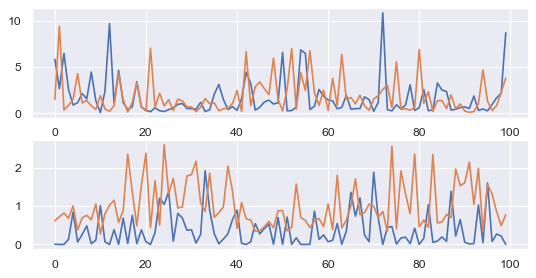

In [11]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 4))
num_plot_points = 100
axes[0].plot(np.arange(num_plot_points), train_dataset.x[:num_plot_points])
axes[1].plot(np.arange(num_plot_points), train_dataset.y[:num_plot_points])

#### Train fixed-step NN models

In [12]:
torch.manual_seed(1)    # reproducible

num_models = 2
fixed_step_models = []
for i in range(num_models):
    # define a network
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 200),
#         torch.nn.BatchNorm1d(200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 200),
#         torch.nn.BatchNorm1d(200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 2),
    )
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    criterion = torch.nn.MSELoss()  # this is for regression mean squared loss
    batch_size = 128
    epochs = 40
    
    scheduler = StepLR(optimizer, step_size=5, gamma=0.8)
    trainer = Trainer(model, criterion, train_dataset, test_dataset, optimizer, scheduler=scheduler,
                      batch_size=batch_size, num_workers=0)
    
    trainer.train(n_epochs=epochs)
    fixed_step_models.append(model)
    print(f"Network: {i+1} trained")


Epoch 1:	Test Loss: 0.03075;	Train Loss: 0.007124;	Time per epoch: 3.029618978500366s	LR: [0.05]
Epoch 2:	Test Loss: 0.038084;	Train Loss: 0.006782;	Time per epoch: 3.0395429134368896s	LR: [0.05]
Epoch 3:	Test Loss: 0.020718;	Train Loss: 0.003152;	Time per epoch: 3.1178040504455566s	LR: [0.05]
Epoch 4:	Test Loss: 0.031279;	Train Loss: 0.00381;	Time per epoch: 3.1755340099334717s	LR: [0.05]
Epoch 5:	Test Loss: 0.031512;	Train Loss: 0.005102;	Time per epoch: 3.1381912231445312s	LR: [0.05]
Epoch 6:	Test Loss: 0.008416;	Train Loss: 0.003346;	Time per epoch: 3.133643865585327s	LR: [0.032]
Epoch 7:	Test Loss: 0.079239;	Train Loss: 0.008186;	Time per epoch: 3.1538660526275635s	LR: [0.04]
Epoch 8:	Test Loss: 0.014694;	Train Loss: 0.005203;	Time per epoch: 3.226732015609741s	LR: [0.04]
Epoch 9:	Test Loss: 0.022425;	Train Loss: 0.00687;	Time per epoch: 3.1583797931671143s	LR: [0.04]
Epoch 10:	Test Loss: 0.011949;	Train Loss: 0.006276;	Time per epoch: 3.2154061794281006s	LR: [0.04]
Epoch 11:	Test

## Train Variable Step Model

In [18]:
train_dataset=lotka_volterra.VariableStepLotkaVolterraDataset(
    simulator, size=50000, min_time_delta=10., max_time_delta=10., samples_per_sim=50, seed=0,
    transform=lotka_volterra.ToTensor())
test_dataset=lotka_volterra.VariableStepLotkaVolterraDataset(
    simulator, size=5000, min_time_delta=10., max_time_delta=10., samples_per_sim=50, seed=1,
    transform=lotka_volterra.ToTensor())

100%|██████████| 100/100 [00:00<00:00, 118.81it/s]


In [23]:
torch.manual_seed(1)    # reproducible

num_models = 1
models = []
batch_size = 128
epochs = 1000

for i in range(num_models):
    model = NeuralNetwork(3, [400, 400, 200], 2, activation_function=torch.tanh,
                        batch_norm=True,dropout_rate=0.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    criterion = torch.nn.MSELoss()  # this is for regression mean squared loss
    
    scheduler = StepLR(optimizer, step_size=60, gamma=0.8)
    trainer = Trainer(model, criterion, train_dataset, test_dataset, optimizer, scheduler=scheduler,
                      batch_size=batch_size, num_workers=0, tensorboard_logdir='runs/variable_step_nn')
    
    trainer.train(n_epochs=epochs)
    models.append(model)
    print(f"Network: {i+1} trained")


Epoch 1:	Test Loss: 2.283196;	Train Loss: 1.854705;	Time per epoch: 6.784791946411133s	LR: [0.2]
Epoch 2:	Test Loss: 2.572128;	Train Loss: 3.66155;	Time per epoch: 6.749540090560913s	LR: [0.2]
Epoch 3:	Test Loss: 2.822922;	Train Loss: 2.837222;	Time per epoch: 6.856484889984131s	LR: [0.2]
Epoch 4:	Test Loss: 4.524321;	Train Loss: 3.300734;	Time per epoch: 6.913623094558716s	LR: [0.2]
Epoch 5:	Test Loss: 3.356593;	Train Loss: 4.766715;	Time per epoch: 6.98757004737854s	LR: [0.2]
Epoch 6:	Test Loss: 4.178887;	Train Loss: 2.533693;	Time per epoch: 7.358164072036743s	LR: [0.2]
Epoch 7:	Test Loss: 2.886038;	Train Loss: 3.256423;	Time per epoch: 7.731706857681274s	LR: [0.2]
Epoch 8:	Test Loss: 2.948599;	Train Loss: 3.212904;	Time per epoch: 7.906630992889404s	LR: [0.2]
Epoch 9:	Test Loss: 3.238105;	Train Loss: 3.091409;	Time per epoch: 7.409312963485718s	LR: [0.2]
Epoch 10:	Test Loss: 2.665606;	Train Loss: 3.323576;	Time per epoch: 7.353853940963745s	LR: [0.2]
Epoch 11:	Test Loss: 2.290457;	

Epoch 85:	Test Loss: 2.113767;	Train Loss: 2.153251;	Time per epoch: 7.978930950164795s	LR: [0.16]
Epoch 86:	Test Loss: 2.591984;	Train Loss: 2.154164;	Time per epoch: 7.970785140991211s	LR: [0.16]
Epoch 87:	Test Loss: 2.212118;	Train Loss: 2.898604;	Time per epoch: 7.967320919036865s	LR: [0.16]
Epoch 88:	Test Loss: 2.122497;	Train Loss: 2.132991;	Time per epoch: 7.982415199279785s	LR: [0.16]
Epoch 89:	Test Loss: 2.6596;	Train Loss: 2.522982;	Time per epoch: 8.111873149871826s	LR: [0.16]
Epoch 90:	Test Loss: 2.40758;	Train Loss: 2.512941;	Time per epoch: 8.277935981750488s	LR: [0.16]
Epoch 91:	Test Loss: 3.373912;	Train Loss: 2.52151;	Time per epoch: 7.9768829345703125s	LR: [0.16]
Epoch 92:	Test Loss: 2.220616;	Train Loss: 2.069904;	Time per epoch: 7.99294900894165s	LR: [0.16]
Epoch 93:	Test Loss: 2.351559;	Train Loss: 3.413273;	Time per epoch: 7.966299057006836s	LR: [0.16]
Epoch 94:	Test Loss: 3.391679;	Train Loss: 2.341107;	Time per epoch: 8.19563627243042s	LR: [0.16]
Epoch 95:	Test 

Epoch 167:	Test Loss: 1.910883;	Train Loss: 2.410522;	Time per epoch: 12.915634155273438s	LR: [0.128]
Epoch 168:	Test Loss: 3.208404;	Train Loss: 2.189335;	Time per epoch: 12.997720956802368s	LR: [0.128]
Epoch 169:	Test Loss: 2.007682;	Train Loss: 2.074809;	Time per epoch: 12.979429721832275s	LR: [0.128]
Epoch 170:	Test Loss: 2.510422;	Train Loss: 2.298141;	Time per epoch: 13.033391237258911s	LR: [0.128]
Epoch 171:	Test Loss: 1.85802;	Train Loss: 2.230239;	Time per epoch: 14.014068126678467s	LR: [0.128]
Epoch 172:	Test Loss: 3.055071;	Train Loss: 2.352654;	Time per epoch: 13.471857070922852s	LR: [0.128]
Epoch 173:	Test Loss: 1.940879;	Train Loss: 2.547037;	Time per epoch: 13.43419861793518s	LR: [0.128]
Epoch 174:	Test Loss: 1.927981;	Train Loss: 2.637116;	Time per epoch: 13.957332849502563s	LR: [0.128]
Epoch 175:	Test Loss: 2.425966;	Train Loss: 2.121883;	Time per epoch: 13.719806909561157s	LR: [0.128]
Epoch 176:	Test Loss: 1.79455;	Train Loss: 2.455701;	Time per epoch: 13.344691991806

Epoch 248:	Test Loss: 1.41466;	Train Loss: 1.878633;	Time per epoch: 8.799742221832275s	LR: [0.0819]
Epoch 249:	Test Loss: 1.640299;	Train Loss: 1.531741;	Time per epoch: 8.698953866958618s	LR: [0.0819]
Epoch 250:	Test Loss: 1.643001;	Train Loss: 1.947031;	Time per epoch: 8.050250053405762s	LR: [0.0819]
Epoch 251:	Test Loss: 1.712087;	Train Loss: 1.572032;	Time per epoch: 8.267705917358398s	LR: [0.0819]
Epoch 252:	Test Loss: 1.613568;	Train Loss: 1.430169;	Time per epoch: 8.704070091247559s	LR: [0.0819]
Epoch 253:	Test Loss: 1.719365;	Train Loss: 1.755019;	Time per epoch: 8.420614242553711s	LR: [0.0819]
Epoch 254:	Test Loss: 1.848414;	Train Loss: 1.472555;	Time per epoch: 7.996484994888306s	LR: [0.0819]
Epoch 255:	Test Loss: 1.58939;	Train Loss: 1.574788;	Time per epoch: 8.03779411315918s	LR: [0.0819]
Epoch 256:	Test Loss: 1.359542;	Train Loss: 1.576828;	Time per epoch: 8.38761281967163s	LR: [0.0819]
Epoch 257:	Test Loss: 1.703442;	Train Loss: 1.669935;	Time per epoch: 8.31308197975158

Epoch 329:	Test Loss: 1.461274;	Train Loss: 1.739833;	Time per epoch: 8.42976689338684s	LR: [0.0655]
Epoch 330:	Test Loss: 1.337561;	Train Loss: 1.106672;	Time per epoch: 8.40891695022583s	LR: [0.0655]
Epoch 331:	Test Loss: 1.388893;	Train Loss: 1.357421;	Time per epoch: 8.614940166473389s	LR: [0.0655]
Epoch 332:	Test Loss: 1.222074;	Train Loss: 1.641459;	Time per epoch: 8.683750867843628s	LR: [0.0655]
Epoch 333:	Test Loss: 1.651876;	Train Loss: 1.762597;	Time per epoch: 8.496524810791016s	LR: [0.0655]
Epoch 334:	Test Loss: 1.593352;	Train Loss: 1.508055;	Time per epoch: 8.435860872268677s	LR: [0.0655]
Epoch 335:	Test Loss: 1.597532;	Train Loss: 1.384159;	Time per epoch: 8.707328081130981s	LR: [0.0655]
Epoch 336:	Test Loss: 1.385596;	Train Loss: 1.559791;	Time per epoch: 8.636022090911865s	LR: [0.0655]
Epoch 337:	Test Loss: 1.398263;	Train Loss: 1.436934;	Time per epoch: 8.502200841903687s	LR: [0.0655]
Epoch 338:	Test Loss: 1.636203;	Train Loss: 1.901108;	Time per epoch: 8.380023002624

Epoch 410:	Test Loss: 1.505084;	Train Loss: 1.445314;	Time per epoch: 8.374038934707642s	LR: [0.0524]
Epoch 411:	Test Loss: 1.368206;	Train Loss: 1.377171;	Time per epoch: 8.341652870178223s	LR: [0.0524]
Epoch 412:	Test Loss: 1.345723;	Train Loss: 1.668377;	Time per epoch: 8.075778722763062s	LR: [0.0524]
Epoch 413:	Test Loss: 1.233441;	Train Loss: 1.376569;	Time per epoch: 8.026348114013672s	LR: [0.0524]
Epoch 414:	Test Loss: 1.34927;	Train Loss: 1.212795;	Time per epoch: 8.34038233757019s	LR: [0.0524]
Epoch 415:	Test Loss: 1.213975;	Train Loss: 1.461114;	Time per epoch: 8.348089694976807s	LR: [0.0524]
Epoch 416:	Test Loss: 1.300104;	Train Loss: 1.28293;	Time per epoch: 8.372967958450317s	LR: [0.0524]
Epoch 417:	Test Loss: 1.308423;	Train Loss: 1.482524;	Time per epoch: 8.428007125854492s	LR: [0.0524]
Epoch 418:	Test Loss: 1.242133;	Train Loss: 1.544923;	Time per epoch: 8.204820156097412s	LR: [0.0524]
Epoch 419:	Test Loss: 1.383527;	Train Loss: 1.369638;	Time per epoch: 8.1507411003112

Epoch 491:	Test Loss: 1.085145;	Train Loss: 1.119606;	Time per epoch: 8.391203165054321s	LR: [0.0336]
Epoch 492:	Test Loss: 1.213164;	Train Loss: 1.1406;	Time per epoch: 8.339336156845093s	LR: [0.0336]
Epoch 493:	Test Loss: 1.127425;	Train Loss: 1.659299;	Time per epoch: 8.023037910461426s	LR: [0.0336]
Epoch 494:	Test Loss: 1.105145;	Train Loss: 1.159372;	Time per epoch: 8.014320135116577s	LR: [0.0336]
Epoch 495:	Test Loss: 1.104072;	Train Loss: 1.283176;	Time per epoch: 8.217276811599731s	LR: [0.0336]
Epoch 496:	Test Loss: 1.038579;	Train Loss: 1.19506;	Time per epoch: 8.463384866714478s	LR: [0.0336]
Epoch 497:	Test Loss: 1.108156;	Train Loss: 1.32942;	Time per epoch: 8.254925012588501s	LR: [0.0336]
Epoch 498:	Test Loss: 1.040153;	Train Loss: 1.447032;	Time per epoch: 8.061048746109009s	LR: [0.0336]
Epoch 499:	Test Loss: 1.094014;	Train Loss: 1.179823;	Time per epoch: 8.337932109832764s	LR: [0.0336]
Epoch 500:	Test Loss: 1.149929;	Train Loss: 1.120596;	Time per epoch: 8.53158712387085

Epoch 572:	Test Loss: 1.001647;	Train Loss: 1.048789;	Time per epoch: 7243.622449874878s	LR: [0.0268]
Epoch 573:	Test Loss: 1.210367;	Train Loss: 1.05393;	Time per epoch: 6.592975854873657s	LR: [0.0268]
Epoch 574:	Test Loss: 1.051183;	Train Loss: 0.879804;	Time per epoch: 2191.288025856018s	LR: [0.0268]
Epoch 575:	Test Loss: 1.074464;	Train Loss: 1.442512;	Time per epoch: 6.7322471141815186s	LR: [0.0268]
Epoch 576:	Test Loss: 1.025515;	Train Loss: 1.348079;	Time per epoch: 139.60833978652954s	LR: [0.0268]
Epoch 577:	Test Loss: 1.047221;	Train Loss: 1.292394;	Time per epoch: 7.720382928848267s	LR: [0.0268]
Epoch 578:	Test Loss: 1.329;	Train Loss: 1.192271;	Time per epoch: 7.010145902633667s	LR: [0.0268]
Epoch 579:	Test Loss: 1.028882;	Train Loss: 1.478243;	Time per epoch: 6.719977140426636s	LR: [0.0268]
Epoch 580:	Test Loss: 1.014046;	Train Loss: 1.23103;	Time per epoch: 6.755539894104004s	LR: [0.0268]
Epoch 581:	Test Loss: 1.043242;	Train Loss: 0.980057;	Time per epoch: 6.6645929813385

Epoch 653:	Test Loss: 0.973729;	Train Loss: 1.347044;	Time per epoch: 7.509567975997925s	LR: [0.0215]
Epoch 654:	Test Loss: 1.197363;	Train Loss: 1.058009;	Time per epoch: 7.162768840789795s	LR: [0.0215]
Epoch 655:	Test Loss: 1.027023;	Train Loss: 1.028519;	Time per epoch: 7.173444747924805s	LR: [0.0215]
Epoch 656:	Test Loss: 1.091886;	Train Loss: 1.41587;	Time per epoch: 7.135196924209595s	LR: [0.0215]
Epoch 657:	Test Loss: 1.135272;	Train Loss: 0.867799;	Time per epoch: 7.184354066848755s	LR: [0.0215]
Epoch 658:	Test Loss: 1.037947;	Train Loss: 1.101214;	Time per epoch: 7.123400926589966s	LR: [0.0215]
Epoch 659:	Test Loss: 1.020067;	Train Loss: 1.090544;	Time per epoch: 7.188159942626953s	LR: [0.0215]
Epoch 660:	Test Loss: 1.062078;	Train Loss: 1.030759;	Time per epoch: 7.215710401535034s	LR: [0.0215]
Epoch 661:	Test Loss: 0.953926;	Train Loss: 1.166919;	Time per epoch: 7.285078048706055s	LR: [0.0137]
Epoch 662:	Test Loss: 0.996746;	Train Loss: 1.084924;	Time per epoch: 7.23399305343

Epoch 734:	Test Loss: 0.938967;	Train Loss: 0.761011;	Time per epoch: 7.2466981410980225s	LR: [0.0137]
Epoch 735:	Test Loss: 0.902153;	Train Loss: 0.947795;	Time per epoch: 7.245361089706421s	LR: [0.0137]
Epoch 736:	Test Loss: 0.964152;	Train Loss: 1.098374;	Time per epoch: 7.249397039413452s	LR: [0.0137]
Epoch 737:	Test Loss: 0.959278;	Train Loss: 0.811192;	Time per epoch: 7.26264500617981s	LR: [0.0137]
Epoch 738:	Test Loss: 0.978898;	Train Loss: 1.004698;	Time per epoch: 7.276084899902344s	LR: [0.0137]
Epoch 739:	Test Loss: 0.968285;	Train Loss: 1.285208;	Time per epoch: 7.2522499561309814s	LR: [0.0137]
Epoch 740:	Test Loss: 0.913813;	Train Loss: 1.283664;	Time per epoch: 7.2095019817352295s	LR: [0.0137]
Epoch 741:	Test Loss: 1.081322;	Train Loss: 0.855545;	Time per epoch: 7.202224016189575s	LR: [0.0137]
Epoch 742:	Test Loss: 1.065289;	Train Loss: 0.788676;	Time per epoch: 7.224229097366333s	LR: [0.0137]
Epoch 743:	Test Loss: 0.964487;	Train Loss: 1.019107;	Time per epoch: 7.26840496

Epoch 815:	Test Loss: 0.929313;	Train Loss: 0.871975;	Time per epoch: 7.0843729972839355s	LR: [0.011]
Epoch 816:	Test Loss: 0.876687;	Train Loss: 1.053865;	Time per epoch: 6.9368109703063965s	LR: [0.011]
Epoch 817:	Test Loss: 0.941626;	Train Loss: 0.85396;	Time per epoch: 6.93604302406311s	LR: [0.011]
Epoch 818:	Test Loss: 0.937649;	Train Loss: 0.964503;	Time per epoch: 6.951987981796265s	LR: [0.011]
Epoch 819:	Test Loss: 0.955454;	Train Loss: 0.887664;	Time per epoch: 7.080688953399658s	LR: [0.011]
Epoch 820:	Test Loss: 0.964334;	Train Loss: 0.954578;	Time per epoch: 6.990599870681763s	LR: [0.011]
Epoch 821:	Test Loss: 0.928181;	Train Loss: 0.965195;	Time per epoch: 7.065922737121582s	LR: [0.011]
Epoch 822:	Test Loss: 0.917898;	Train Loss: 0.906285;	Time per epoch: 7.084933757781982s	LR: [0.011]
Epoch 823:	Test Loss: 0.925135;	Train Loss: 1.040314;	Time per epoch: 7.065194129943848s	LR: [0.011]
Epoch 824:	Test Loss: 0.921025;	Train Loss: 1.189701;	Time per epoch: 7.113669157028198s	LR

Epoch 896:	Test Loss: 0.860783;	Train Loss: 0.835766;	Time per epoch: 7.051303148269653s	LR: [0.0088]
Epoch 897:	Test Loss: 0.879778;	Train Loss: 0.849058;	Time per epoch: 7.093898057937622s	LR: [0.0088]
Epoch 898:	Test Loss: 0.92866;	Train Loss: 0.98743;	Time per epoch: 7.055999040603638s	LR: [0.0088]
Epoch 899:	Test Loss: 0.887748;	Train Loss: 0.940993;	Time per epoch: 6.95844578742981s	LR: [0.0088]
Epoch 900:	Test Loss: 0.940642;	Train Loss: 0.992969;	Time per epoch: 6.942257881164551s	LR: [0.0088]
Epoch 901:	Test Loss: 0.888048;	Train Loss: 1.202669;	Time per epoch: 6.85444712638855s	LR: [0.0056]
Epoch 902:	Test Loss: 0.846626;	Train Loss: 1.060493;	Time per epoch: 6.934465646743774s	LR: [0.007]
Epoch 903:	Test Loss: 0.849615;	Train Loss: 0.84748;	Time per epoch: 6.9617719650268555s	LR: [0.007]
Epoch 904:	Test Loss: 0.869018;	Train Loss: 0.890306;	Time per epoch: 6.859595775604248s	LR: [0.007]
Epoch 905:	Test Loss: 0.876092;	Train Loss: 1.068289;	Time per epoch: 6.9339470863342285s

Epoch 978:	Test Loss: 0.842916;	Train Loss: 0.825203;	Time per epoch: 7.586846351623535s	LR: [0.0056]
Epoch 979:	Test Loss: 0.848342;	Train Loss: 1.018244;	Time per epoch: 7.620558023452759s	LR: [0.0056]
Epoch 980:	Test Loss: 0.904705;	Train Loss: 0.893867;	Time per epoch: 7.764969110488892s	LR: [0.0056]
Epoch 981:	Test Loss: 0.88294;	Train Loss: 0.967562;	Time per epoch: 8.829943895339966s	LR: [0.0056]
Epoch 982:	Test Loss: 0.86695;	Train Loss: 0.947005;	Time per epoch: 8.230053901672363s	LR: [0.0056]
Epoch 983:	Test Loss: 0.871712;	Train Loss: 0.791868;	Time per epoch: 7.073373079299927s	LR: [0.0056]
Epoch 984:	Test Loss: 0.876138;	Train Loss: 0.76607;	Time per epoch: 7.5669801235198975s	LR: [0.0056]
Epoch 985:	Test Loss: 0.850602;	Train Loss: 0.787328;	Time per epoch: 7.206305980682373s	LR: [0.0056]
Epoch 986:	Test Loss: 0.869385;	Train Loss: 0.873115;	Time per epoch: 7.216702938079834s	LR: [0.0056]
Epoch 987:	Test Loss: 0.881451;	Train Loss: 0.840045;	Time per epoch: 7.176545858383

#### Plot variable step model predictions

In [ ]:
# Plot the predictions for variable step models
num_steps = 1600
sim_data = simulator.run_simulation(2.1, 2.8, num_steps - 1)
steps = np.arange(num_steps)

# Run the predictions:
model = models[0]
model.eval()
preds = []
with torch.no_grad():
    for i in range(1, num_steps):
        sim_input = sim_data[i]
        output = model(torch.from_numpy(np.array([2.1, 2.8, (i - 600)/200])).float()).numpy()
        preds.append(output)
preds = np.stack(preds, axis=0)

In [ ]:
preds

In [ ]:
colors = sns.color_palette("husl", 4)
plt.plot(steps, sim_data[:, 0], 'g',  linewidth=3.5, label='Prey', color=colors[0], alpha=0.4)
plt.plot(steps, sim_data[:, 1], 'r',  linewidth=3.5, label='Predator', color=colors[2], alpha=0.4)


plt.plot(steps[601:801], preds[600:800, 0], '--', linewidth=1.2, color='black', label='Predicted Prey')
plt.plot(steps[601:801], preds[600:800, 1], '--', linewidth=1.2, color=(0.2, 0.2, 0.3), label='Predicted Predator')
plt.legend()

plt.arrow(0.0, 3.7, 600., 0.0, head_width=0.06, head_length=30, linewidth=1, color='black', length_includes_head=True)
plt.arrow(600.0, 3.7, -600., 0.0, head_width=0.06, head_length=30, linewidth=1, color='black', length_includes_head=True)

plt.text(130, 3.8, s='$\\tau$')
plt.xlim(0, num_steps)
plt.ylim(0, 5.05)

## Plot fixed step model predictions

#### Ensemble

In [13]:
# Plot the predictions for fixed step models
num_points = 1000
# Eval. input and output times
eval_inputs = np.linspace(0, tau, num_points, endpoint=False)
eval_outputs = eval_inputs+tau
# All eval. times
eval_times = np.concatenate((eval_inputs, eval_inputs+tau))
sim_data = simulator.run_simulation(2.1, 2.8, eval_times)

# Run the predictions:
for model in fixed_step_models:
    model.eval()
preds = []
stds = []
with torch.no_grad():
    for i in range(num_points):
        sim_input = sim_data[i]
        outputs = [model(torch.from_numpy(sim_input).float()).numpy() for model in fixed_step_models]
        outputs = np.stack(outputs, axis=0)
        mean = np.mean(outputs, axis=0)
        std = np.std(outputs, axis=0)
        preds.append(mean)
        stds.append(std)
preds = np.stack(preds, axis=0)
stds = np.stack(stds, axis=0)*20

##### Show ensemble predictions

(0, 5.05)

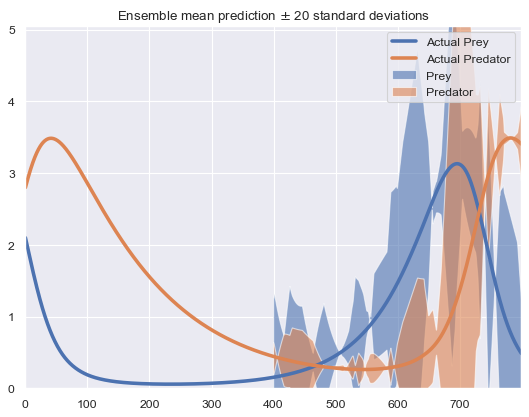

In [14]:
plt.fill_between(eval_outputs, preds[:, 0] - stds[:, 0], preds[:, 0] + stds[:, 0], alpha=0.6, label='Prey')
plt.fill_between(eval_outputs, preds[:, 1] - stds[:, 1], preds[:, 1] + stds[:, 1], alpha=0.6, label='Predator')
plt.plot(eval_times, sim_data[:, 0],  linewidth=3.2, label='Actual Prey', alpha=1, zorder=1)
plt.plot(eval_times, sim_data[:, 1],  linewidth=3.2, label='Actual Predator', alpha=1, zorder=1)
plt.title('Ensemble mean prediction $\pm$ 20 standard deviations')
plt.legend()
plt.xlim(0, eval_times[-1])
plt.ylim(0, 5.05)

#### Single model

In [15]:
# Plot the predictions for constant step models
num_points = 1000
eval_inputs = np.linspace(0, tau, num_points, endpoint=False)
eval_times = np.concatenate((eval_inputs, eval_inputs+tau))
sim_data = simulator.run_simulation(2.1, 2.8, eval_times)

# Run the predictions:
for model in fixed_step_models:
    model.eval()
preds = []
model = fixed_step_models[0]
with torch.no_grad():
    outputs = model(torch.from_numpy(sim_data[:num_points]).float()).numpy()
    preds.append(outputs)
preds = outputs

###### Plot single model pred

(0, 5.05)

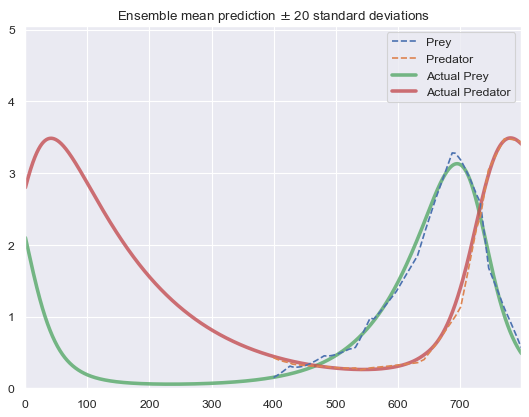

In [16]:
plt.plot(eval_outputs, preds[:, 0], '--', label='Prey')
plt.plot(eval_outputs, preds[:, 1], '--', label='Predator')
plt.plot(eval_times, sim_data[:, 0],  linewidth=3.2, label='Actual Prey', alpha=0.8, zorder=1)
plt.plot(eval_times, sim_data[:, 1],  linewidth=3.2, label='Actual Predator', alpha=0.8, zorder=1)
plt.title('Ensemble mean prediction $\pm$ 20 standard deviations')
plt.legend()
plt.xlim(0, eval_times[-1])
plt.ylim(0, 5.05)

#### Illustartive prediction task plot

In [89]:
prey_name = 'Fish (in millions)'
predator_name = "Seal (in thousands)"

(0, 4.85)

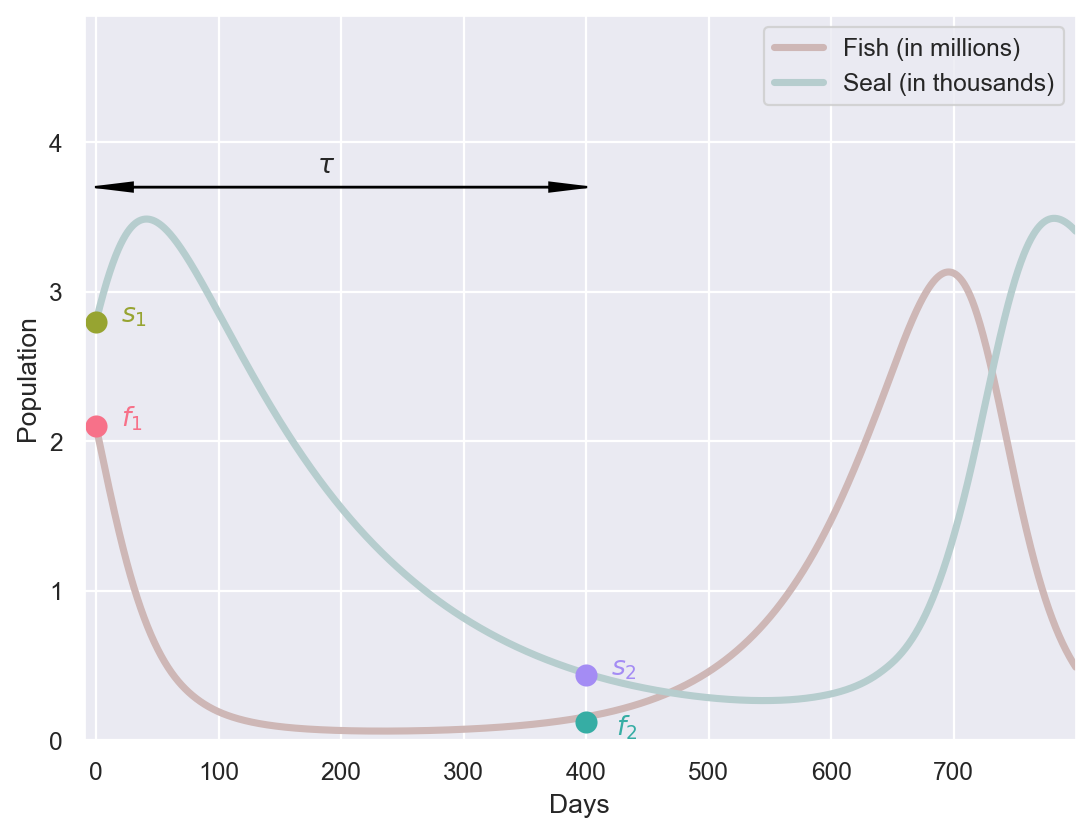

In [90]:
colors = sns.color_palette("husl", 4)
lines_colors= sns.hls_palette(2, s=.2, l=0.76)
plt.plot(eval_times, sim_data[:, 0],  linewidth=3.2, label=prey_name, color=lines_colors[0], alpha=1, zorder=1)
plt.plot(eval_times, sim_data[:, 1],  linewidth=3.2, label=predator_name, color=lines_colors[1], alpha=1, zorder=1)


# plt.plot(steps[tau:], preds[:-tau, 0], '--', linewidth=1.2, color='black', label=f'Predicted {prey_name}')
# plt.plot(steps[tau:], preds[:-tau, 1], '--', linewidth=1.2, color=(0.2, 0.2, 0.3), label=f'Predicted {predator_name}')
plt.scatter(0, sim_data[0, 0], marker='o', alpha=1.0, color=colors[0], s=80, zorder=2)
plt.scatter(0, sim_data[0, 1], marker='o', alpha=1.0, color=colors[1], s=80, zorder=2)
plt.scatter(tau, preds[0, 0], marker='o', alpha=1.0, color=colors[2], s=80, zorder=2)
plt.scatter(tau, preds[0, 1], marker='o', alpha=1.0, color=colors[3], s=80, zorder=2)
txt_x_shift = 20
plt.text(0 + txt_x_shift, sim_data[0, 0], s='$f_1$', color=colors[0])
plt.text(0 + txt_x_shift, sim_data[0, 1], s='$s_1$', color=colors[1])
plt.text(tau + txt_x_shift + 4, preds[0, 0] - 0.082, s='$f_2$', color=colors[2])
plt.text(tau + txt_x_shift, preds[0, 1], s='$s_2$', color=colors[3])


# plt.fill_between(steps[300:], preds[:-300, 0] - stds[:-300, 0], preds[:-300, 0] + stds[:-300, 0], alpha=0.6)
# plt.fill_between(steps[300:], preds[:-300, 1] - stds[:-300, 1], preds[:-300, 1] + stds[:-300, 1], alpha=0.6)
plt.legend()

plt.arrow(0.0, 3.7, tau, 0.0, head_width=0.06, head_length=30, linewidth=1, color='black', length_includes_head=True)
plt.arrow(tau, 3.7, -tau, 0.0, head_width=0.06, head_length=30, linewidth=1, color='black', length_includes_head=True)

plt.xlabel('Days')
plt.ylabel('Population')

plt.text(180, 3.8, s='$\\tau$')
plt.xlim(-10, eval_times[-1])
plt.ylim(0, 4.85)
# plt.savefig('../plots/forwards_model.eps', bbox_inches='tight', format='eps')


# Conditional VAE

###### Make the VAE Dataset

In [30]:
tau=400.
train_dataset=lotka_volterra.FixedStepLotkaVolterraDataset(
    simulator, size=100000, time_delta=tau, samples_per_sim=1, seed=0, transform=lotka_volterra.ToTensor())
test_dataset=lotka_volterra.FixedStepLotkaVolterraDataset(
    simulator, size=5000, time_delta=tau, samples_per_sim=2, seed=1, transform=lotka_volterra.ToTensor())

100%|██████████| 2500/2500 [00:09<00:00, 271.05it/s]


In [17]:
# Only the predator (seal) is observed
train_dataset_vae = lotka_volterra.LotkaVolterraDataset(simulator, size=train_dataset.size,
                                                        transform=train_dataset.transform)
train_dataset_vae.x = train_dataset.x[:, [1]]
train_dataset_vae.y = train_dataset.y[:, [1]]

test_dataset_vae = lotka_volterra.LotkaVolterraDataset(simulator, size=test_dataset.size,
                                                        transform=test_dataset.transform)
test_dataset_vae.x = test_dataset.x[:, [1]]
test_dataset_vae.y = test_dataset.y[:, [1]]

###### Setup and train the CondVAE

In [18]:
torch.manual_seed(1)

condvae_model = ConditionalVAE(1, 1, 1, 200, num_hidden_layers=2)
condvae_model.train()
optimizer = torch.optim.Adam(condvae_model.parameters(), lr=2e-2)
batch_size = 128
epochs = 100

scheduler = StepLR(optimizer, step_size=5, gamma=0.7)
trainer = CondVAETrainer(condvae_model, train_dataset_vae, test_dataset_vae, optimizer=optimizer, scheduler=scheduler,
                  batch_size=batch_size, num_workers=0, obs_sigma=1e-2)

trainer.train(n_epochs=epochs)

Epoch 1:	Test Loss: 527.871545;	Train Loss: 1082.613255;	Time per epoch: 9.834840059280396s	LR: [0.02]
Epoch 2:	Test Loss: 510.238365;	Train Loss: 925.892378;	Time per epoch: 9.869286060333252s	LR: [0.02]
Epoch 3:	Test Loss: 530.23481;	Train Loss: 836.462071;	Time per epoch: 9.914872169494629s	LR: [0.02]
Epoch 4:	Test Loss: 495.168995;	Train Loss: 898.797956;	Time per epoch: 9.899203777313232s	LR: [0.02]
Epoch 5:	Test Loss: 464.286078;	Train Loss: 734.57094;	Time per epoch: 9.769917011260986s	LR: [0.02]
Epoch 6:	Test Loss: 508.696426;	Train Loss: 645.495815;	Time per epoch: 9.819236993789673s	LR: [0.0098]
Epoch 7:	Test Loss: 470.2607;	Train Loss: 854.482413;	Time per epoch: 9.87029504776001s	LR: [0.014]
Epoch 8:	Test Loss: 477.969627;	Train Loss: 668.462446;	Time per epoch: 9.888187170028687s	LR: [0.014]
Epoch 9:	Test Loss: 481.753072;	Train Loss: 649.599339;	Time per epoch: 9.769118070602417s	LR: [0.014]
Epoch 10:	Test Loss: 481.43186;	Train Loss: 853.814723;	Time per epoch: 9.8372430

Epoch 79:	Test Loss: 494.098289;	Train Loss: 500.802351;	Time per epoch: 35.17352890968323s	LR: [9.e-05]
Epoch 80:	Test Loss: 496.30075;	Train Loss: 495.149715;	Time per epoch: 10.842836856842041s	LR: [9.e-05]
Epoch 81:	Test Loss: 495.137952;	Train Loss: 505.41966;	Time per epoch: 10.732128620147705s	LR: [5.e-05]
Epoch 82:	Test Loss: 495.202014;	Train Loss: 497.836666;	Time per epoch: 11.251260757446289s	LR: [7.e-05]
Epoch 83:	Test Loss: 498.211858;	Train Loss: 503.032837;	Time per epoch: 10.652860879898071s	LR: [7.e-05]
Epoch 84:	Test Loss: 495.947565;	Train Loss: 504.166059;	Time per epoch: 10.739145994186401s	LR: [7.e-05]
Epoch 85:	Test Loss: 497.685302;	Train Loss: 495.105203;	Time per epoch: 11.382496118545532s	LR: [7.e-05]
Epoch 86:	Test Loss: 495.940678;	Train Loss: 497.771371;	Time per epoch: 10.295573949813843s	LR: [3.e-05]
Epoch 87:	Test Loss: 497.693413;	Train Loss: 507.074672;	Time per epoch: 10.024064779281616s	LR: [5.e-05]
Epoch 88:	Test Loss: 496.295726;	Train Loss: 490.

###### Plot true latent vs. predictions

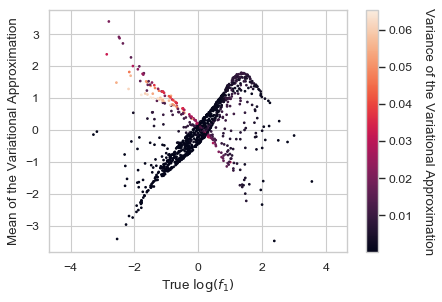

In [56]:
num_points = 1000
f1, s1 = np.random.lognormal(size=[num_points]), np.random.lognormal(size=[num_points])
f2, s2 = np.zeros_like(f1), np.zeros_like(s1)
for i in range(num_points):
    sim_data = simulator.run_simulation(f1[i], s1[i], [tau])
    f2[i], s2[i] = sim_data[0]

# Predict f1 from s1, s2
with torch.no_grad():
    f1_pred_mean, f1_pred_logvar = condvae_model.encode(torch.tensor(s2[:, None]).float(), torch.tensor(s1[:, None]).float())
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(6,4))
    plt.scatter(np.log(f1), f1_pred_mean, s=2.0, c=np.exp(f1_pred_logvar))
    cbar = plt.colorbar()
    cbar.set_label('Variance of the Variational Approximation', rotation=270, labelpad=20)
#     ax.set_aspect('equal')
    plt.xlabel('True $\log( f_1)$')
    plt.ylabel('Mean of the Variational Approximation')
    ax.axis('equal')
    plt.xlim(-3, 3)
#     plt.ylim(-3, 3)

# plt.savefig('../plots/variational_approx_to_f1.eps', bbox_inches='tight', format='eps')

### Conditiona VAE - use both observations at time t_2

In [20]:
train_dataset_vae = lotka_volterra.LotkaVolterraDataset(simulator, size=train_dataset.size,
                                                        transform=train_dataset.transform)
train_dataset_vae.x = train_dataset.x[:, [1]]
train_dataset_vae.y = train_dataset.y[:, :]

test_dataset_vae = lotka_volterra.LotkaVolterraDataset(simulator, size=test_dataset.size,
                                                        transform=test_dataset.transform)
test_dataset_vae.x = test_dataset.x[:, [1]]
test_dataset_vae.y = test_dataset.y[:, :]

In [21]:
torch.manual_seed(1)

condvae_model_full = ConditionalVAE(2, 1, 1, 200, num_hidden_layers=2)
condvae_model_full.train()
optimizer = torch.optim.Adam(condvae_model_full.parameters(), lr=1e-2)
batch_size = 128
epochs = 100

scheduler = StepLR(optimizer, step_size=4, gamma=0.7)
trainer = CondVAETrainer(condvae_model_full, train_dataset_vae, test_dataset_vae, optimizer=optimizer, scheduler=scheduler,
                  batch_size=batch_size, num_workers=0, obs_sigma=2e-1)

trainer.train(n_epochs=epochs)

Epoch 1:	Test Loss: 126.106691;	Train Loss: 220.430117;	Time per epoch: 10.682505130767822s	LR: [0.01]
Epoch 2:	Test Loss: 133.802901;	Train Loss: 191.108623;	Time per epoch: 10.916840076446533s	LR: [0.01]
Epoch 3:	Test Loss: 128.942499;	Train Loss: 190.012569;	Time per epoch: 10.734392642974854s	LR: [0.01]
Epoch 4:	Test Loss: 125.929012;	Train Loss: 189.067926;	Time per epoch: 10.986884117126465s	LR: [0.01]
Epoch 5:	Test Loss: 134.617373;	Train Loss: 194.247766;	Time per epoch: 11.338958978652954s	LR: [0.0049]
Epoch 6:	Test Loss: 123.546294;	Train Loss: 189.438836;	Time per epoch: 10.586422204971313s	LR: [0.007]
Epoch 7:	Test Loss: 130.565313;	Train Loss: 188.471817;	Time per epoch: 10.630081176757812s	LR: [0.007]
Epoch 8:	Test Loss: 132.208247;	Train Loss: 185.973192;	Time per epoch: 10.36320686340332s	LR: [0.007]
Epoch 9:	Test Loss: 122.880668;	Train Loss: 188.097305;	Time per epoch: 11.001920223236084s	LR: [0.00343]
Epoch 10:	Test Loss: 133.708035;	Train Loss: 187.453877;	Time per 

Epoch 79:	Test Loss: 129.490038;	Train Loss: 188.282109;	Time per epoch: 10.533715963363647s	LR: [1.e-05]
Epoch 80:	Test Loss: 129.483878;	Train Loss: 177.211583;	Time per epoch: 11.318327188491821s	LR: [1.e-05]
Epoch 81:	Test Loss: 129.747707;	Train Loss: 182.014193;	Time per epoch: 11.020872831344604s	LR: [1.e-05]
Epoch 82:	Test Loss: 129.187237;	Train Loss: 178.835279;	Time per epoch: 10.94770884513855s	LR: [1.e-05]
Epoch 83:	Test Loss: 129.517635;	Train Loss: 179.664228;	Time per epoch: 10.770548105239868s	LR: [1.e-05]
Epoch 84:	Test Loss: 129.547038;	Train Loss: 186.48919;	Time per epoch: 11.2865891456604s	LR: [1.e-05]
Epoch 85:	Test Loss: 129.767382;	Train Loss: 187.967494;	Time per epoch: 10.912395000457764s	LR: [0.]
Epoch 86:	Test Loss: 129.687686;	Train Loss: 182.725133;	Time per epoch: 10.986546993255615s	LR: [1.e-05]
Epoch 87:	Test Loss: 129.757213;	Train Loss: 185.176969;	Time per epoch: 10.704760074615479s	LR: [1.e-05]
Epoch 88:	Test Loss: 129.715727;	Train Loss: 184.66996

###### Plot true latent vs. predictions

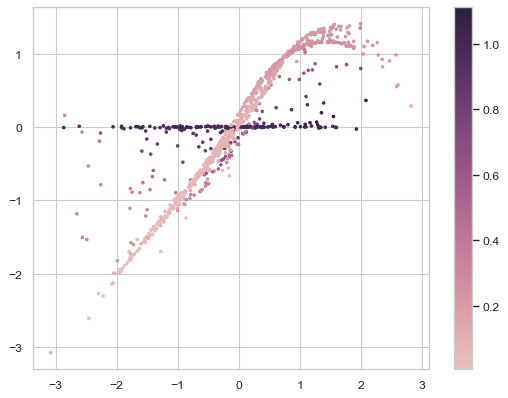

In [198]:
num_points = 1000
f1, s1 = np.random.lognormal(size=[num_points]), np.random.lognormal(size=[num_points])
f2, s2 = np.zeros_like(f1), np.zeros_like(s1)
for i in range(num_points):
    sim_data = simulator.run_simulation(f1[i], s1[i], [tau])
    f2[i], s2[i] = sim_data[0]

# Predict f1 from s1, s2
with torch.no_grad():
        f1_pred_mean, f1_pred_logvar = condvae_model_full.encode(
            torch.tensor(np.stack([f2, s2],axis=1)).float(), torch.tensor(s1[:, None]).float())
with sns.axes_style('whitegrid'):
    plt.scatter(np.log(f1), f1_pred_mean, s=5.0, c=np.exp(f1_pred_logvar), cmap=sns.cubehelix_palette(light=0.8, as_cmap=True))
    plt.colorbar()
    ax.set_xlabel('Actual $\log( f_1)$')
    ax.set_ylabel('Mean of variational prediction of $\log (f_1)$')
    ax.set_aspect('equal')


## Neural ODEs

In [ ]:
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
from causalitydemos.models import ODEFunc

In [ ]:
train_dataset=lotka_volterra.SequenceLotkaVolterraDataset(
    simulator, size=3000, time_batch_size=40, subsample_sim=10, seed=0)
test_dataset=lotka_volterra.SequenceLotkaVolterraDataset(
    simulator, size=1000, time_batch_size=400, seed=0)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=False)
testloader = torch.utils.data.DataLoader(test_dataset,
                                     batch_size=16,
                                     shuffle=False,
                                     num_workers=0,
                                     pin_memory=False)

In [ ]:
func = ODEFunc()

In [ ]:
optimizer = torch.optim.RMSprop(func.parameters(), lr=1e-5)

for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        batch_x, batch_y, batch_t = data
        batch_t = batch_t[0]
        batch_y = torch.transpose(batch_y, 0, 1)

        optimizer.zero_grad()
        
        pred_y = odeint_adjoint(func, batch_x, batch_t, rtol=1e-3, atol=1e-6)
        loss = torch.mean(torch.abs(pred_y - batch_y)**2)
        loss.backward()
        optimizer.step()
        print(f'Iteration: {i}; Train loss: {loss.item()}')

## Counterfactual

In [81]:
model = fixed_step_models[0]
sigma=0.01
tau=400.
res= 1000
sim_time_max = tau  # Time to simulate until
eval_times = np.linspace(0, sim_time_max, res, endpoint=True).astype(np.float32)
res=1.0 
num_points = 10000# Num_points

In [82]:
# s1 - initial predator, f1 - initial prey
# f1_true, s1  = np.random.lognormal(), np.random.lognormal()
f1_true, s1 = 0.8, 1.83
sim_data = simulator.run_simulation(f1_true, s1, eval_times)
f2, s2 = tuple(sim_data[-1, :])
print(f'f1: {f1_true}, s1: {s1}, f2: {f2}, s2: {s2}')

f1: 0.8, s1: 1.83, f2: 0.9735964510017332, s2: 0.8407165853313453


In [83]:
f1_grid = np.linspace(1e-5, 20, num_points)
f1_probs = lognorm.pdf(f1_grid, 1)
s1_grid = np.ones_like(f1_grid) * s1
x_grid = np.stack([f1_grid, s1_grid], axis=1)

# Calculate p(y | x_1, x_2)
with torch.no_grad():
    outputs = model(torch.from_numpy(x_grid).float()).numpy()

y_grid_prob = scipy.stats.norm.pdf((outputs[:, 1] - s2)/sigma)
f1_posterior = f1_probs * y_grid_prob

#### Plot posterior over f1

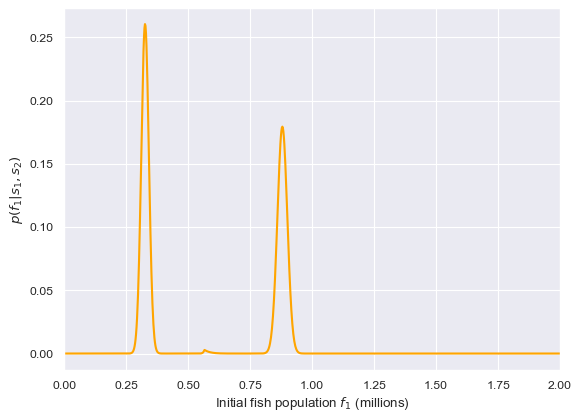

In [60]:
# plt.axvline(f1_true, color=(0.2, 0.2, 0.2, 0.8), linewidth=0.8)
plt.plot(f1_grid, f1_posterior, color='orange', linewidth=1.9)
# plt.xlim(0, 4)
plt.xlabel('Initial fish population $f_1$ (millions)')
plt.ylabel('$p(f_1 | s_1, s_2)$')
# Add the True x2 tick
plt.xlim(0, 2)
plt.draw()
ax = plt.gca()
# labels = [w.get_text() for w in ax.get_xticklabels()]
# locs=list(ax.get_xticks())
# labels+=['True $f_1$']
# locs+=[f1_true]
# ax.set_xticklabels(labels)
# ax.set_xticks(locs);
# plt.savefig('../plots/initial_fish_posterior_without_true.eps', bbox_inches='tight', format='eps')


##### Now with true f_1 marked

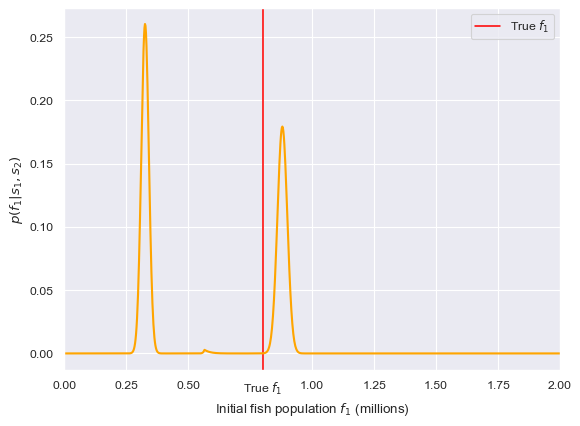

In [61]:
plt.axvline(f1_true, color='red', linewidth=1.4, label='True $f_1$')
plt.plot(f1_grid, f1_posterior, color='orange', linewidth=1.9)

plt.xlabel('Initial fish population $f_1$ (millions)')
plt.ylabel('$p(f_1 | s_1, s_2)$')
# Add the True x2 tick
plt.xlim(0, 2)
plt.draw()
ax = plt.gca()
labels = [w.get_text() for w in ax.get_xticklabels()]
locs=list(ax.get_xticks())
del locs[3], labels[3]
labels+=['True $f_1$']
locs+=[f1_true]
ax.set_xticklabels(labels)
ax.set_xticks(locs);
plt.legend()
# plt.savefig('../plots/initial_fish_posterior_with_true.eps', bbox_inches='tight', format='eps')


In [62]:
f1_grid[np.argmax(f1_posterior)]

0.3260424402440244

### True simulation plot

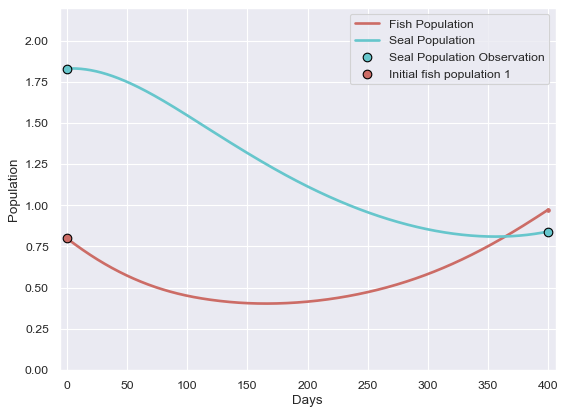

In [26]:
with sns.axes_style("darkgrid"):
    colors= sns.hls_palette(2, s=.5)
    plt.plot(eval_times, sim_data[:, 0], label='Fish Population', color=colors[0], linewidth=2.4, zorder=1)
    plt.plot(eval_times, sim_data[:, 1], label='Seal Population', color=colors[1], linewidth=2.4, zorder=1)
    plt.scatter([0, tau], sim_data[[0, -1], 1], label="Seal Population Observation", color=colors[1], edgecolor='black', s=60, zorder=2)
    plt.scatter(0, f1_true, label="Initial fish population 1", color=colors[0], edgecolor='black', s=60, zorder=2)
    plt.scatter(tau, sim_data[-1, 0], color=colors[0], s=10, zorder=2)


    # plt.scatter([0, tau], sim_data2[[0, tau], 1])
    plt.ylim(0, 2.2)
    plt.xlim(-6, 406)
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
# plt.savefig('../plots/init_fish_explanation1_true.eps', bbox_inches='tight', format='eps')


### True simulation - alternative input

In [27]:
sim_data2 = simulator.run_simulation(0.36604642064206416, s1 , tau)

with sns.axes_style("darkgrid"):
    colors= sns.hls_palette(2, s=.5)
    plt.plot(np.arange(tau+1), sim_data2[:, 0], label='Fish Population', color=colors[0], linewidth=2.4, zorder=1)
    plt.plot(np.arange(tau+1), sim_data2[:, 1], label='Seal Population', color=colors[1], linewidth=2.4, zorder=1)
    plt.scatter([0, tau], sim_data[[0, tau], 1], label="Seal Population Observation", color=colors[1], edgecolor='black', s=60, zorder=2)
    plt.scatter(0, sim_data2[0, 0], label="Initial fish population 1", color=colors[0], edgecolor='black', s=60, zorder=2)
    plt.scatter(tau, sim_data2[tau, 0], color=colors[0], s=10, zorder=2)


    # plt.scatter([0, tau], sim_data2[[0, tau], 1])
    plt.ylim(0, 2.2)
    plt.xlim(-6, 406)
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
plt.savefig('../plots/init_fish_explanation2.eps', bbox_inches='tight', format='eps')


TypeError: eval_times has to be a 1D numpy array, or a list/tuple of type that can be cast to float

### True simulation (2nd plot)

ValueError: x and y must have same first dimension, but have shapes (401,) and (1000,)

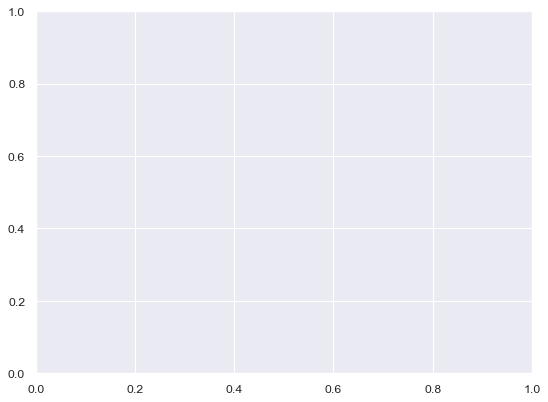

In [29]:
with sns.axes_style("darkgrid"):
    colors= sns.hls_palette(2, s=.5)
    plt.plot(np.arange(tau+1), sim_data[:, 0], label='Actual Fish Population', color=colors[0], linewidth=2.4, zorder=1)
    plt.plot(np.arange(tau+1), sim_data[:, 1], label='Actual Seal Population', color=colors[1], linewidth=2.4, zorder=1)
    plt.scatter([0, tau], sim_data[[0, tau], 0], color=colors[0], s=70, zorder=2)
    plt.scatter([0, tau], sim_data[[0, tau], 1], color=colors[1], s=70, zorder=2)

    # plt.scatter([0, tau], sim_data2[[0, tau], 1])
    plt.ylim(0, 2.9)
    plt.xlim(-1, 400)
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
plt.savefig('../plots/true-simulated_fish_population.eps', bbox_inches='tight', format='eps')


### True simulation - counterfactual input

In [30]:
# Counterfactual s_1*
s1_cf = 2.7

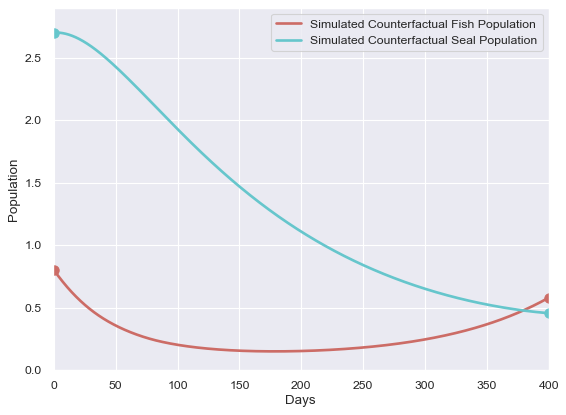

In [31]:
sim_data_cf = simulator.run_simulation(f1_true, s1_cf , eval_times)

with sns.axes_style("darkgrid"):
    colors= sns.hls_palette(2, s=.5)
    plt.plot(eval_times, sim_data_cf[:, 0], label='Simulated Counterfactual Fish Population', color=colors[0], linewidth=2.4, zorder=1)
    plt.plot(eval_times, sim_data_cf[:, 1], label='Simulated Counterfactual Seal Population', color=colors[1], linewidth=2.4, zorder=1)
    plt.scatter([0, tau], sim_data_cf[[0, -1], 0], color=colors[0], s=70, zorder=2)
    plt.scatter([0, tau], sim_data_cf[[0, -1], 1], color=colors[1], s=70, zorder=2)

    # plt.scatter([0, tau], sim_data2[[0, tau], 1])
    plt.ylim(0, 2.9)
    plt.xlim(-1, 400)
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
# plt.savefig('../plots/true-counterfactual-simulated_fish_population.eps', bbox_inches='tight', format='eps')


#### Posterior over s2*

In [32]:
x_grid_cf = np.stack([f1_grid, np.ones_like(f1_grid)*s1_cf], axis=1)
# Calculate p(s_2* | s_1*, f_1)
with torch.no_grad():
    outputs = model(torch.from_numpy(x_grid_cf).float()).numpy()
s2_cf_means = outputs[:, 1]

In [33]:
# Calculate the posterior
# s2_grid = np.linspace(s2_cf_means.min() - sigma*4, s2_cf_means.max() + sigma*4, 4000)
s2_grid= np.linspace(0, 4, 10000)
s2_cf_unnorm_posterior = np.zeros_like(s2_grid)
for s2_sample_mean, sample_prob in zip(s2_cf_means, f1_posterior):
    s2_cf_unnorm_posterior += scipy.stats.norm.pdf(s2_grid, loc=s2_sample_mean, scale=sigma) * sample_prob

In [34]:
# Simulate the actual answer
sim_data_cf = simulator.run_simulation(f1_true, s1_cf, eval_times)
f2_cf_true, s2_cf_true =  tuple(sim_data_cf[-1, :])

#### Plot w\o true marker

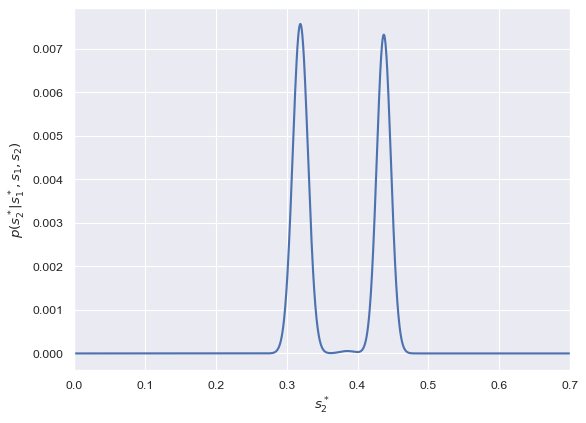

In [35]:
plt.plot(s2_grid, s2_cf_unnorm_posterior / s2_cf_unnorm_posterior.sum(), linewidth=1.9)

plt.xlim(s2_grid[0], 0.7)

plt.xlabel('$s_2^*$')
plt.ylabel('$p(s_2^* | s_1^*, s_1, s_2)$');

# plt.savefig('../plots/counterfactual_seal_posterior_without_true.eps', bbox_inches='tight', format='eps')

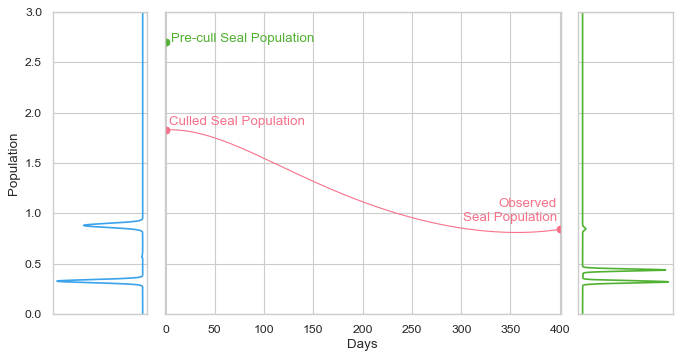

In [36]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 4.2, 1], 'wspace':0.09, 'hspace':0.05}, figsize=(10, 5), sharey=True)

    # Plot simulation data
    colors = sns.color_palette('husl', 3)

    # Real seal population
    axes[1].plot(eval_times, sim_data[:, 1], color=colors[0], linewidth=1.0)
    axes[1].scatter([0, tau], [sim_data[0, 1], sim_data[-1, 1]],  color=colors[0], label="Observed Seal Population")
    axes[1].text(4, sim_data[0, 1] + 0.05, 'Culled Seal Population', horizontalalignment='left', color=colors[0])
    axes[1].text(tau - 3, sim_data[-1, 1]+0.08, 'Observed\nSeal Population', horizontalalignment='right', color=colors[0])

    # Counter-factual (no cull) population
    # axes[1].plot(np.arange(tau + 1), sim_data_cf[:, 1], '--',color=colors[1], linewidth=1.0)
    axes[1].scatter([0], [sim_data_cf[0, 1]], color=colors[1], label="Counterfactual Seal Population")
    # axes[1].scatter(tau, sim_data_cf[tau, 1], linestyle=':', s=160, facecolors='none', edgecolors=colors[1], linewidth=1.0)
    axes[1].text(6, sim_data_cf[0, 1], 'Pre-cull Seal Population', horizontalalignment='left', color=colors[1])
    # axes[1].text(tau + 15, sim_data_cf[tau, 1]- 0.1, 'Counterfactual Inferred\nSeal Population', horizontalalignment='left', color=colors[1])
#     axes[1].scatter([0], [f1_true], color=colors[2], label="True Initial Fish Population")
#     axes[1].scatter(0, f1_true, linestyle=':', s=160, facecolors='none', edgecolors=colors[2], linewidth=1.0)

#     axes[1].text(6, f1_true+0.03, 'True Initial Fish Population', horizontalalignment='left', color=colors[2])


    axes[1].set_xlabel('Days')
    axes[1].set_xlim(-1, tau+1)
    # axes[1].get_yaxis().set_visible(False)

    # Fish posterior
    axes[0].plot(-f1_posterior, f1_grid, label='$p(f_1 | s_1, s_2)$', color=colors[2])
    axes[0].get_xaxis().set_visible(False)
    axes[0].set_ylabel('Population')

#     axes[0].legend()

    # Counterfactual seal posterior
    axes[2].plot(s2_cf_unnorm_posterior / s2_cf_unnorm_posterior.sum(), s2_grid, color=colors[1])
    axes[2].get_xaxis().set_visible(False)
    # axes[2].get_yaxis().set_visible(False)


    for ax in axes:
        ax.set_ylim(0, 3)

# plt.legend()
# plt.savefig('../plots/observed-and-all-posteriors.eps', bbox_inches='tight', format='eps')


#### All posteriors but with simulated groundtruth

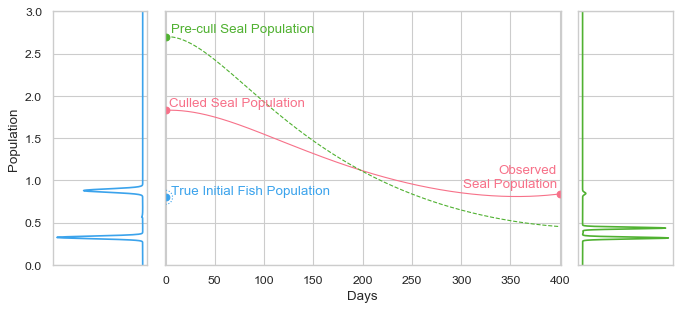

In [37]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 4.2, 1], 'wspace':0.09, 'hspace':0.05}, figsize=(10, 4.2), sharey=True)

    # Plot simulation data
    colors = sns.color_palette('husl', 3)

    # Real seal population
    axes[1].plot(eval_times, sim_data[:, 1], color=colors[0], linewidth=1.0)
    axes[1].scatter([0, tau], [sim_data[0, 1], sim_data[-1, 1]],  color=colors[0], label="Observed Seal Population")
    axes[1].text(4, sim_data[0, 1] + 0.05, 'Culled Seal Population', horizontalalignment='left', color=colors[0])
    axes[1].text(tau - 3, sim_data[-1, 1]+0.08, 'Observed\nSeal Population', horizontalalignment='right', color=colors[0])

    # Counter-factual (no cull) population
    axes[1].plot(eval_times, sim_data_cf[:, 1], '--',color=colors[1], linewidth=1.0)
    axes[1].scatter([0], [sim_data_cf[0, 1]], color=colors[1], label="Counterfactual Seal Population")
    # axes[1].scatter(tau, sim_data_cf[tau, 1], linestyle=':', s=160, facecolors='none', edgecolors=colors[1], linewidth=1.0)
    axes[1].text(6, sim_data_cf[0, 1]+0.05, 'Pre-cull Seal Population', horizontalalignment='left', color=colors[1])
    # axes[1].text(tau + 15, sim_data_cf[tau, 1]- 0.1, 'Counterfactual Inferred\nSeal Population', horizontalalignment='left', color=colors[1])
    axes[1].scatter([0], [f1_true], color=colors[2], label="True Initial Fish Population")
    axes[1].scatter([0], [f1_true], linestyle=':', s=160, facecolors='none', edgecolors=colors[2], linewidth=1.0)
    axes[1].text(6, f1_true+0.03, 'True Initial Fish Population', horizontalalignment='left', color=colors[2])

    axes[1].set_xlabel('Days')
    axes[1].set_xlim(-1, tau+1)
    # axes[1].get_yaxis().set_visible(False)

    # Fish posterior
    axes[0].plot(-f1_posterior, f1_grid, label='$p(f_1 | s_1, s_2)$', color=colors[2])
    axes[0].get_xaxis().set_visible(False)
#     axes[0].get_yaxis().set_visible(False)

    axes[0].set_ylabel('Population')
#     axes[0].text(-.254, 0.95, 'Inferred Initial Fish Population', horizontalalignment='left', color=colors[2],
#                  bbox=dict(boxstyle="round",
#                    ec=(1., 1, 1),
#                    fc=(1., 1, 1), alpha=0.8,
#                    ), rotation=90)

    # axes[0].legend()

    # Counterfactual seal posterior
    axes[2].plot(s2_cf_unnorm_posterior / s2_cf_unnorm_posterior.sum(), s2_grid, color=colors[1])
    axes[2].get_xaxis().set_visible(False)
#     axes[2].text(.0052, 1.42, 'Inferred Counterfactual\nSeal Population', horizontalalignment='left',
#                  bbox=dict(boxstyle="round",
#                    ec=(1., 1, 1),
#                    fc=(1., 1, 1), alpha=0.8,
#                    ), color=colors[1], rotation=-90)
#     axes[2].set_xlabel('$p(s_2^* |s_1, s_2, s_1^*)$')
    # axes[2].get_yaxis().set_visible(False)


    for ax in axes:
        ax.set_ylim(0, 3)

# plt.legend()
plt.savefig('../plots/observed-and-all-posteriors-and-ground-truth.eps', bbox_inches='tight', format='eps')


#### Plot same with true

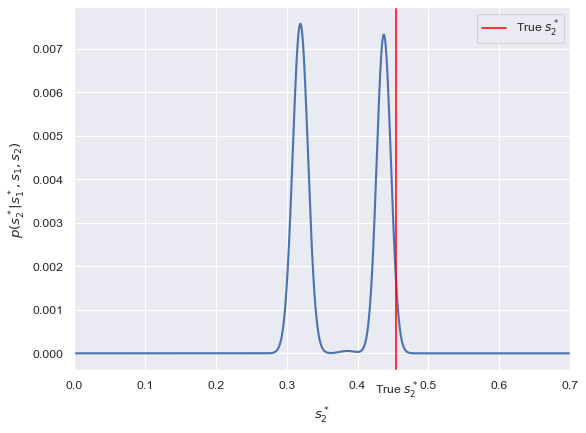

In [38]:
plt.plot(s2_grid, s2_cf_unnorm_posterior / s2_cf_unnorm_posterior.sum(), linewidth=1.9)
plt.axvline(s2_cf_true, color='red', linewidth=1.4, label='True $s_2^*$')
plt.xlim(s2_grid[0], 0.7)

# Add the True s2* tick
plt.draw()
ax = plt.gca()
labels = [w.get_text() for w in ax.get_xticklabels()]
locs=list(ax.get_xticks())
# del locs[-3], labels[-3]
labels+=['True $s_2^*$']
locs+=[s2_cf_true]
ax.set_xticklabels(labels)
ax.set_xticks(locs);
plt.xlim(s2_grid[0], 0.7)


plt.xlabel('$s_2^*$')
plt.ylabel('$p(s_2^* | s_1^*, s_1, s_2)$');

plt.legend()

# plt.savefig('../plots/counterfactual_seal_posterior_with_true.eps', bbox_inches='tight', format='eps')

### Scatter of true vs predicted counterfactual

In [ ]:
num_points = 400
true_cf_list, pred_mean_cf_list = [], []
for _ in range(num_points):
    s1, f1, s1_cf = np.random.lognormal(), np.random.lognormal(), np.random.lognormal()
    num_mc_samples = 2000
    decoder_sigma= 5e-1
    f1_samples = np.random.lognormal(size=[num_mc_samples, 1])

    # Calculate p(s_2|s_1, f_1) for each sample
    with torch.no_grad():
        sample_inputs = (torch.from_numpy(f1_samples).float(), torch.from_numpy( np.ones_like(f1_samples)*s1).float())
        prob_observed = model(torch.from_numpy(x_grid).float()).numpy()
    # Weight each sample by probability of actual s_2 given decoder:
    sample_weights =  scipy.stats.norm.pdf((prob_observed[:, 0] - s2)/decoder_sigma)
    if sample_weights.sum() > 0.:
        sample_weights /= sample_weights.sum()

        # Calculate p(s_2* | s_1*, f_1)
        with torch.no_grad():
            sample_inputs = (torch.from_numpy(f1_samples).float(), torch.from_numpy(np.ones_like(f1_samples)*s1_cf).float())
            mean_of_pred_cf = condvae_model.decode(*sample_inputs).numpy()
        s2_cf_means = mean_of_pred_cf[:, 0]

        pred_mean_cf_list.append((s2_cf_means*sample_weights).sum())
    else:
        pred_mean_cf_list.append(1.0)
    # Calculate the true CF
    sim_data = simulator.run_simulation(f1, s1, [tau])
    f2, s2 = sim_data[0]
    true_cf_list.append(s2)
    

# Same, but for CondVAE

In [63]:
num_mc_samples = 1000
decoder_sigma= 1e-1

f1_samples = np.random.lognormal(size=[num_mc_samples, 1])

# Calculate p(s_2|s_1, f_1) for each sample
with torch.no_grad():
    sample_inputs = (torch.from_numpy(f1_samples).float(), torch.from_numpy( np.ones_like(f1_samples)*s1).float())
    prob_observed = condvae_model.decode(*sample_inputs).numpy()
# Weight each sample by probability of actual s_2 given decoder:
sample_weights =  scipy.stats.norm.pdf((prob_observed[:, 0] - s2)/decoder_sigma)

# Calculate p(s_2* | s_1*, f_1)
with torch.no_grad():
    sample_inputs = (torch.from_numpy(f1_samples).float(), torch.from_numpy(np.ones_like(f1_samples)*s1_cf).float())
    mean_of_pred_cf = condvae_model.decode(*sample_inputs).numpy()
s2_cf_means = mean_of_pred_cf[:, 0]

In [64]:
# Calculate the posterior
# s2_grid = np.linspace(s2_cf_means.min() - sigma*4, s2_cf_means.max() + sigma*4, 4000)
s2_grid= np.linspace(0, 4, 10000)
s2_cf_unnorm_posterior = np.zeros_like(s2_grid)
for s2_sample_mean, sample_prob in zip(s2_cf_means, sample_weights):
    s2_cf_unnorm_posterior += scipy.stats.norm.pdf(s2_grid, loc=s2_sample_mean, scale=decoder_sigma) * sample_prob

###### Plot posterior on s^* with true

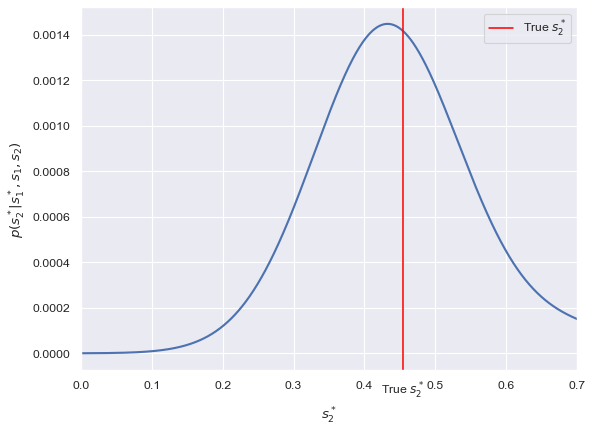

In [65]:
plt.plot(s2_grid, s2_cf_unnorm_posterior / s2_cf_unnorm_posterior.sum(), linewidth=1.9)
plt.axvline(s2_cf_true, color='red', linewidth=1.4, label='True $s_2^*$')
plt.xlim(s2_grid[0], 0.7)

# Add the True s2* tick
plt.draw()
ax = plt.gca()
labels = [w.get_text() for w in ax.get_xticklabels()]
locs=list(ax.get_xticks())
# del locs[-3], labels[-3]
labels+=['True $s_2^*$']
locs+=[s2_cf_true]
ax.set_xticklabels(labels)
ax.set_xticks(locs);
plt.xlim(s2_grid[0], 0.7)


plt.xlabel('$s_2^*$')
plt.ylabel('$p(s_2^* | s_1^*, s_1, s_2)$');

plt.legend()

# plt.savefig('../plots/counterfactual_seal_posterior_with_true.eps', bbox_inches='tight', format='eps')

###### Variational Approximation to posterior on latent f_1

In [66]:
with torch.no_grad():
    sample_inputs = (torch.from_numpy(f1_samples).float(), torch.from_numpy(np.ones_like(f1_samples)*s1_cf).float())
    variational_posterior_mean, variational_posterior_logvar = condvae_model.encode(
        torch.tensor([[s2]]), torch.tensor([[s1]]))
f1_variational_posterior = scipy.stats.norm.pdf(np.log(f1_grid), loc=variational_posterior_mean, scale=np.sqrt(np.exp(variational_posterior_logvar)))
f1_variational_posterior = f1_variational_posterior.ravel()

###### True Posterior on latent

In [67]:
# Calculate p(f_1|s_1, s_2) propto p(s_2|f_1, s_1)p(f_1) for each sample
with torch.no_grad():
    grid_input = (torch.from_numpy(f1_grid[:, None]).float(), torch.from_numpy(np.ones_like(f1_grid[:, None])*s1).float())
    prob_observation_mean = condvae_model.decode(*grid_input).numpy()

# Weight each sample by probability of actual s_2 given decoder:
prob_observation =  scipy.stats.norm.pdf((prob_observation_mean[:, 0] - s2)/decoder_sigma)
f1_posterior = prob_observation * scipy.stats.norm.pdf( np.log(f1_grid))
f1_posterior /= f1_posterior.sum()

##### Detailed plot with all posteriors for VAE CF prediction

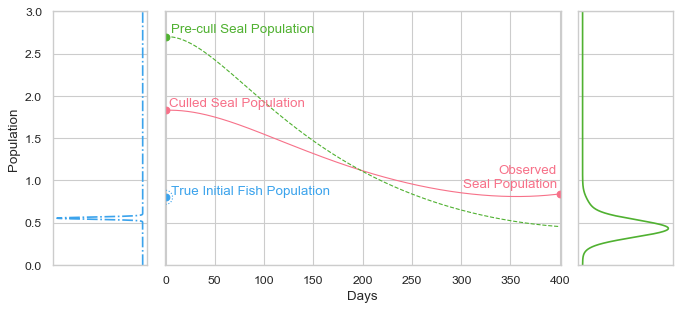

In [68]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 4.2, 1], 'wspace':0.09, 'hspace':0.05}, figsize=(10, 4.2), sharey=True)

    # Plot simulation data
    colors = sns.color_palette('husl', 3)

    # Real seal population
    axes[1].plot(eval_times, sim_data[:, 1], color=colors[0], linewidth=1.0)
    axes[1].scatter([0, tau], [sim_data[0, 1], sim_data[-1, 1]],  color=colors[0], label="Observed Seal Population")
    axes[1].text(4, sim_data[0, 1] + 0.05, 'Culled Seal Population', horizontalalignment='left', color=colors[0])
    axes[1].text(tau - 3, sim_data[-1, 1]+0.08, 'Observed\nSeal Population', horizontalalignment='right', color=colors[0])

    # Counter-factual (no cull) population
    axes[1].plot(eval_times, sim_data_cf[:, 1], '--',color=colors[1], linewidth=1.0)
    axes[1].scatter([0], [sim_data_cf[0, 1]], color=colors[1], label="Counterfactual Seal Population")
    # axes[1].scatter(tau, sim_data_cf[tau, 1], linestyle=':', s=160, facecolors='none', edgecolors=colors[1], linewidth=1.0)
    axes[1].text(6, sim_data_cf[0, 1]+0.05, 'Pre-cull Seal Population', horizontalalignment='left', color=colors[1])
    # axes[1].text(tau + 15, sim_data_cf[tau, 1]- 0.1, 'Counterfactual Inferred\nSeal Population', horizontalalignment='left', color=colors[1])
    axes[1].scatter([0], [f1_true], color=colors[2], label="True Initial Fish Population")
    axes[1].scatter([0], [f1_true], linestyle=':', s=160, facecolors='none', edgecolors=colors[2], linewidth=1.0)
    axes[1].text(6, f1_true+0.03, 'True Initial Fish Population', horizontalalignment='left', color=colors[2])

    axes[1].set_xlabel('Days')
    axes[1].set_xlim(-1, tau+1)
    # axes[1].get_yaxis().set_visible(False)

    # Fish posterior
#     axes[0].plot(-f1_posterior, f1_grid, label='$p(f_1 | s_1, s_2)$', color=colors[2])
    axes[0].plot(-f1_variational_posterior, f1_grid, '-.', label='$p(f_1 | s_1, s_2)$', color=colors[2])

    axes[0].get_xaxis().set_visible(False)
#     axes[0].get_yaxis().set_visible(False)

    axes[0].set_ylabel('Population')

    # Counterfactual seal posterior
    axes[2].plot(s2_cf_unnorm_posterior / s2_cf_unnorm_posterior.sum(), s2_grid, color=colors[1])
    axes[2].get_xaxis().set_visible(False)


    for ax in axes:
        ax.set_ylim(0, 3)

# plt.legend()
# plt.savefig('../plots/observed-and-all-posteriors-and-ground-truth-cond-vae.eps', bbox_inches='tight', format='eps')


### True CF vs. predicted mean of CF plot (scatter)

In [79]:
num_points = 400
true_cf_list, pred_mean_cf_list = [], []
for _ in range(num_points):
    s1, f1, s1_cf = np.random.lognormal(), np.random.lognormal(), np.random.lognormal()
    num_mc_samples = 2000
    decoder_sigma= 5e-1
    f1_samples = np.random.lognormal(size=[num_mc_samples, 1])

    # Calculate p(s_2|s_1, f_1) for each sample
    with torch.no_grad():
        sample_inputs = (torch.from_numpy(f1_samples).float(), torch.from_numpy( np.ones_like(f1_samples)*s1).float())
        prob_observed = condvae_model.decode(*sample_inputs).numpy()
    # Weight each sample by probability of actual s_2 given decoder:
    sample_weights =  scipy.stats.norm.pdf((prob_observed[:, 0] - s2)/decoder_sigma)
    if sample_weights.sum() > 0.:
        sample_weights /= sample_weights.sum()

        # Calculate p(s_2* | s_1*, f_1)
        with torch.no_grad():
            sample_inputs = (torch.from_numpy(f1_samples).float(), torch.from_numpy(np.ones_like(f1_samples)*s1_cf).float())
            mean_of_pred_cf = condvae_model.decode(*sample_inputs).numpy()
        s2_cf_means = mean_of_pred_cf[:, 0]

        pred_mean_cf_list.append((s2_cf_means*sample_weights).sum())
    else:
        pred_mean_cf_list.append(1.0)
    # Calculate the true CF
    sim_data = simulator.run_simulation(f1, s1, [tau])
    f2, s2 = sim_data[0]
    true_cf_list.append(s2)
    

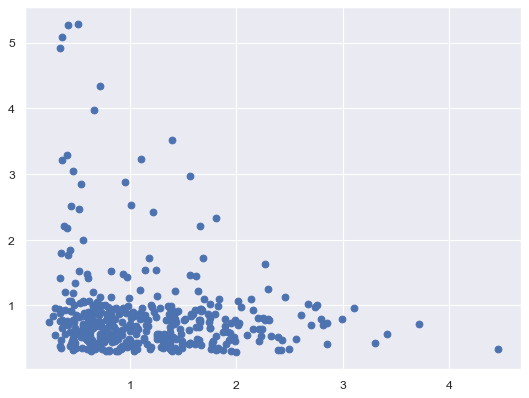

In [80]:
plt.scatter(true_cf_list, pred_mean_cf_list)

### Inference problem explained plot

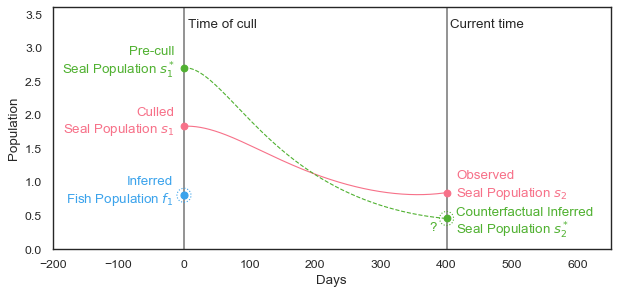

In [227]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(9, 4))
    # Plot simulation data
    colors = sns.color_palette('husl', 3)

    # Real seal population
    plt.plot(eval_times, sim_data[:, 1], color=colors[0], linewidth=1.0)
    plt.scatter([0, tau], [sim_data[0, 1], sim_data[-1, 1]],  color=colors[0], label="Observed Seal Population")
    plt.text(-14, sim_data[0, 1]-0.1, 'Culled\nSeal Population $s_1$', horizontalalignment='right', color=colors[0])
    plt.text(tau + 15, sim_data[-1, 1]-0.05, 'Observed\nSeal Population $s_2$', horizontalalignment='left', color=colors[0])

    # Counter-factual (no cull) population
    plt.plot(eval_times, sim_data_cf[:, 1], '--',color=colors[1], linewidth=1.0)
    plt.scatter([0, tau], [sim_data_cf[0, 1], sim_data_cf[-1, 1]], color=colors[1], label="Counterfactual Seal Population")
    plt.scatter(tau, sim_data_cf[-1, 1], linestyle=':', s=160, facecolors='none', edgecolors=colors[1], linewidth=1.0)
    plt.text(-14, sim_data_cf[0, 1]-0.1, 'Pre-cull\nSeal Population $s_1^*$', horizontalalignment='right', color=colors[1])
    plt.text(tau + 15, sim_data_cf[-1, 1]- 0.24, 'Counterfactual Inferred\nSeal Population $s_2^*$', horizontalalignment='left', color=colors[1])
    # Question mark
    plt.text(tau - 15, sim_data_cf[-1, 1]- 0.18, '?', horizontalalignment='right', color=colors[1])


    # Fish population
    plt.scatter(0, f1_true, linestyle=':', s=160, facecolors='none', edgecolors=colors[2], linewidth=1.0)
    plt.scatter(0, f1_true, s=40, facecolors=colors[2])
    plt.text(-16, f1_true - 0.1, 'Inferred\nFish Population $f_1$', horizontalalignment='right', color=colors[2])



    plt.xlabel('Days')

    # Time lines
    plt.axvline(0, color='grey', zorder=0)
    plt.axvline(tau, color='grey', zorder=0)
    plt.text(6, 3.3, 'Time of cull')
    plt.text(tau + 6, 3.3, 'Current time')

    plt.ylim(0, 3.6)
    plt.xlim(-200, tau+250)
    plt.ylabel('Population')
    plt.draw()
    # plt.legend()
    plt.savefig('../plots/counterfactual-inference-sealfish-illustrative.eps', bbox_inches='tight', format='eps')
